In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, csr_array

#Import Standard Random Walks
from polytopewalk.dense import BallWalk, HitAndRun

#Import Barrier Random Walks
from polytopewalk.dense import DikinWalk, VaidyaWalk, JohnWalk, DikinLSWalk

#Import Initialization Algorithm
from polytopewalk.dense import DenseCenter

#Import Facial Reduction Algorithm 
from polytopewalk import FacialReduction

In [2]:
#Simplex to sample from 
def generate_simplex(d):
    return np.array([1/d] * d), np.array([[1] * d]), np.array([1]), d, 'simplex'

In [3]:
#Initialize Barrier Walks, r = radius of ellipsoid, thin = which sample you keep
dikin = DikinWalk(r = 0.8, thin = 2)
vaidya = VaidyaWalk(r = 0.8, thin = 2)
john = JohnWalk(r = 0.8, thin = 2)

In [4]:
#Initialize Polytope in Full-Dimensional Form

fr = FacialReduction()
_, A, b, k, name = generate_simplex(5)

polytope = fr.reduce(A, b, k, sparse = False)
dense_A = polytope.dense_A
dense_b = polytope.dense_b

dc = DenseCenter()
init = dc.getInitialPoint(dense_A, dense_b)

In [5]:
#Run Random Walk MCMC Sampler
dikin_res = dikin.generateCompleteWalk(1_000, init, dense_A, dense_b, burn = 100)
vaidya_res = vaidya.generateCompleteWalk(1_000, init, dense_A, dense_b, burn = 100)
john_res = john.generateCompleteWalk(1_000, init, dense_A, dense_b, burn = 100)

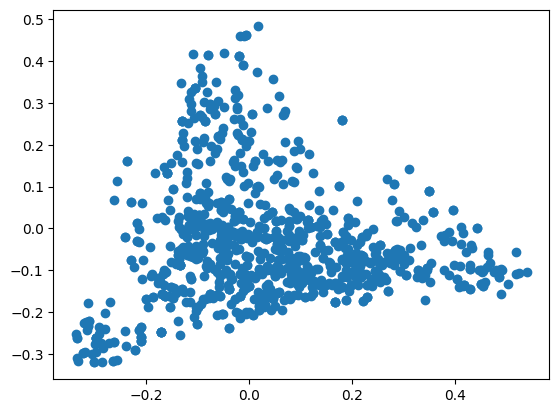

In [6]:
#Plot 2 dimensions of Dikin Walk
plt.scatter(dikin_res[:, 0], dikin_res[:, 1])

In [7]:
#Import End-to-End Pipeline
from polytopewalk import denseFullWalkRun

In [8]:
#Does Facial Reduction & Converts back to Higher Dimension
walk_res = denseFullWalkRun(A, b, k, 4000, dikin, fr, dc)

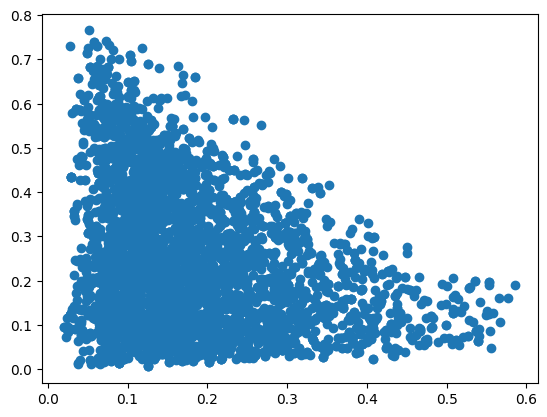

In [9]:
plt.scatter(walk_res[:, 0], walk_res[:, 1])
plt.show()